In [1]:
import pandas as pd
import numpy as np
import torch
import utils.print as print_f
import os

from utils.engine import evaluate, get_iou_types
from utils.plot import plot_losses, plot_performance

from models.utils import get_model_size_in_MB
from models.build import create_model_from_setup
from models.setup import ModelSetup
from models.train import TrainingInfo
from utils.save import check_best, end_train, get_data_from_metric_logger
from data.load import get_datasets, get_dataloaders
from IPython.display import clear_output
from utils.train import get_optimiser, get_lr_scheduler, print_params_setup, get_coco_eval_params, get_dynamic_loss
from utils.init import reproducibility, clean_memory_get_device
from data.paths import MIMIC_EYE_PATH
# from datetime import datetime
# from models.dynamic_loss import DynamicWeightedLoss
from utils.engine import train_one_epoch, evaluate
from torch import optim
from data.paths import MIMIC_EYE_PATH
from models.load import get_trained_model
# from data.load import seed_worker, get_dataloader_g


## Suppress the assignement warning from pandas.r
pd.options.mode.chained_assignment = None  # default='warn'

## Supress user warning
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
from enum import Enum
class TrainedModels(Enum):
    mobilenet_with_fix = "val_lesion-detection_froc_0_7916_test_lesion-detection_froc_0_8150_epoch15_04-01-2023 03-02-43_lesion_dsetection_with_fix_mobilenet"
    mobilenet_baseline = "val_lesion-detection_froc_0_7764_test_lesion-detection_froc_0_8036_epoch8_04-01-2023 07-46-01_lesion_dsetection_baseline_mobilenet"
    resnet18_baseline = "val_lesion-detection_froc_0_7893_test_lesion-detection_froc_0_8075_epoch5_04-01-2023 13-53-42_lesion_dsetection_baseline_resnet18"
    resnet18_with_fix = "val_lesion-detection_froc_0_7982_test_lesion-detection_froc_0_8257_epoch5_04-01-2023 11-24-08_lesion_dsetection_with_fix_resnet18"
    densenet_with_fix = "val_lesion-detection_froc_0_8004_test_lesion-detection_froc_0_8169_epoch12_04-02-2023 03-08-03_lesion_dsetection_with_fix_densenet"
    densenet_baseline = "val_lesion-detection_froc_0_7841_test_lesion-detection_froc_0_7864_epoch7_04-02-2023 06-38-49_lesion_dsetection_baseline_densenet"
    efficientnet_b5_with_fix = "val_lesion-detection_froc_0_7980_test_lesion-detection_froc_0_8006_epoch7_04-02-2023 19-25-56_lesion_dsetection_with_fix_efficientnet_b5"
    efficientnet_b5_baseline = "val_lesion-detection_froc_0_7846_test_lesion-detection_froc_0_8189_epoch5_04-02-2023 22-14-38_lesion_dsetection_baseline_efficientnet_b5"
    # this one doesn't follow the pattern.
    ## val_lesion-detection_froc_0_7939_test_lesion-detection_froc_0_8115_epoch5_04-02-2023 15-17-34_lesion_dsetection_baseline_efficientnet_b0
    ## val_lesion-detection_froc_0_8030_test_lesion-detection_froc_0_8089_epoch7_04-02-2023 12-42-11_lesion_dsetection_with_fix_efficientnet_b0

In [3]:
device = clean_memory_get_device()
reproducibility()

This notebook will running on device: [CUDA]


In [4]:
get_epoch_from_model = lambda select_model: int(([substr for substr in select_model.value.split("_") if "epoch" in substr][0]).replace("epoch", ""))
get_model_name = lambda select_model: str(select_model).split(".")[-1]

In [5]:
select_model = TrainedModels.mobilenet_baseline

In [6]:
model, train_info, optimizer, dynamic_loss_weight = get_trained_model(
        select_model,
        device,
    )

model.to(device)
model.train()

print()

Using pretrained backbone. mobilenet_v3
Using SGD as optimizer with lr=0.01



========================================For Training [lesion_dsetection_baseline_mobilenet]========================================
ModelSetup(get_performance_iou=None, get_performance_areaRng='all', name='lesion_dsetection_baseline_mobilenet', sources=['xrays'], tasks=['lesion-detection'], fusor='element-wise sum', decoder_channels=[128, 64, 32, 16, 8], lesion_label_cols=['Pulmonary edema', 'Enlarged cardiac silhouette', 'Consolidation', 'Atelectasis', 'Pleural abnormality'], save_early_stop_model=True, record_training_performance=False, backbone='mobilenet_v3', optimiser='sgd', lr=0.01, weight_decay=1e-05, sgb_momentum=0.9, image_backbone_pretrained=True, heatmap_backbone_pretrained=False, image_size=512, image_mean=[0.485, 0.456, 0.406], image_std=[0.229, 0.224, 0.225], backbone_out_channels=64, batch_size=8, warmup_epochs=0, model_warmup_epochs=0, loss_warmup_epochs=0, lr_scheduler='ReduceLROnPlateau', reduceLROnPlateau_factor=0.5, reduceLROnPlateau_patience=10, reduceLROnPlateau_f

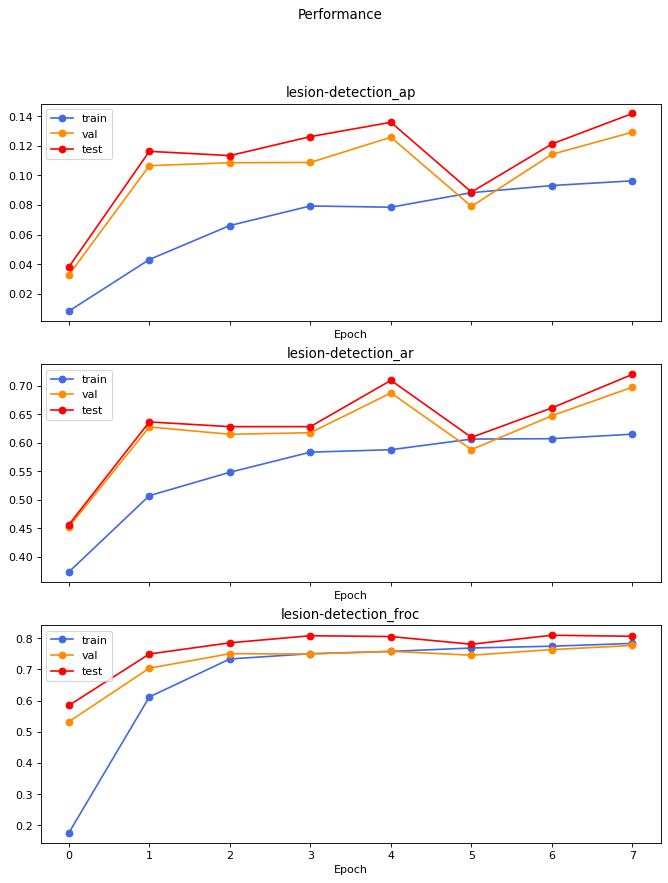

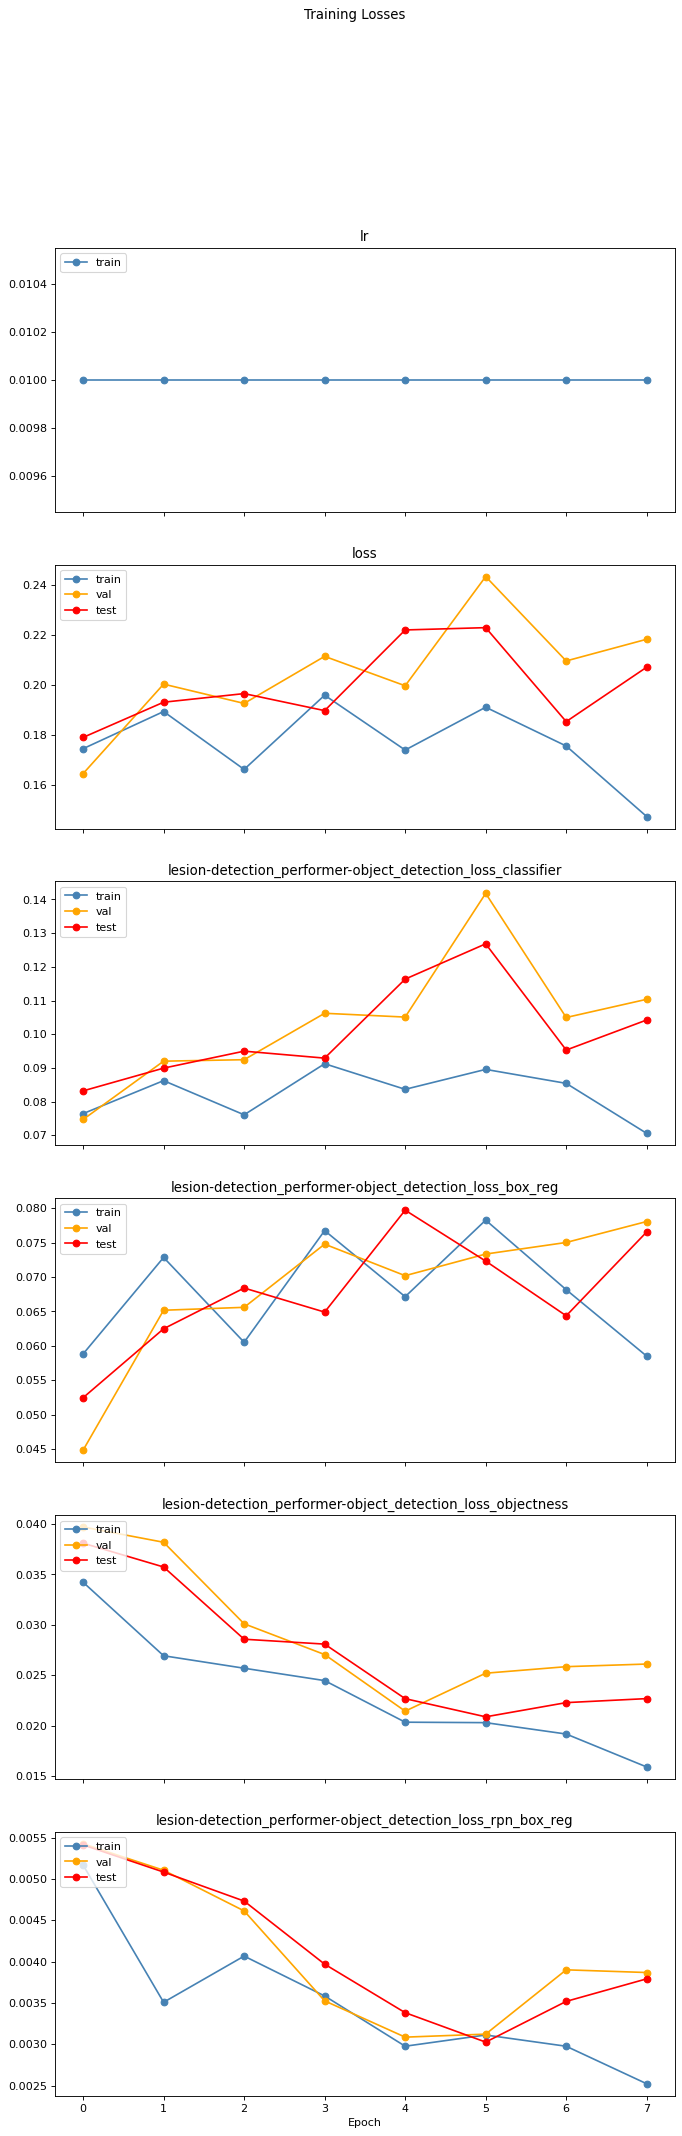

In [7]:
print(train_info)
plot_performance(
    performance=train_info.performance,
    all_tasks=train_info.all_tasks,
    fig_title="Performance",
)
plot_losses(
    train_info.train_losses,
    train_info.val_losses,
    test_logers=train_info.test_losses,
)